# Model Evaluation and Selection

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import math

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from hmmlearn.hmm import GaussianHMM, GMMHMM, MultinomialHMM

from dateutil.relativedelta import relativedelta
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(3, len(s)+1))

In [3]:
## GLOBAL VARS
DATE_TIME = 'date_time'
DATE = 'date'
TIME = 'time'
OPEN_PRICE = 'open'
HIGH_PRICE = 'high'
LOW_PRICE = 'low'
CLOSE_PRICE = 'close'
VOLUME = 'volume'
TURNOVER = 'turnover'
VWAP = 'vwap'
FEATURES = ['high_low_spread', "open_close_rets", "log_total_traded_vol", "daily_log_return", "short_term_vol", "long_term_vol", "money_flow_index"]

## Functions

In [4]:
def loadData(file):
    filepath = os.path.join(DATAPATH, file)
    df = pd.read_csv("file:///" + filepath, parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

    return df

def formatData(df):
    returned_df = df.copy()
    returned_df.drop(labels=["<PER>", "<OPENINT>"], axis="columns", inplace=True)
    returned_df.columns = ['date_time', 'ticker', 'open', 'high', 'low', 'close', 'volume']
    returned_df.set_index('date_time', drop=True, inplace=True)
    returned_df = addDateAndTime(returned_df)

    return returned_df

def prepareDataframe(df):
    returned_df = df.copy()
    returned_df['volume*price'] = returned_df['volume']*returned_df['close']
    returned_df = returned_df.resample('5T').sum()
    returned_df = returned_df.between_time('9:00', '17:25')
    returned_df = returned_df[returned_df.index.weekday != 5]
    returned_df = returned_df[returned_df.index.weekday != 6]
    returned_df['vwap'] = returned_df['volume*price']/returned_df['volume']

    return returned_df

def splitTrainTestData(df, size_in_years):
#     training_data = df[df.index[0]:df.index[0] + relativedelta(years=size_in_years, hours=-9, minutes = -5)]
#     test_data = df[df.index[0] + relativedelta(years=size_in_years, hours=-9):]
    training_data = df[df.index[0]:df.index[-1] - relativedelta(years=size_in_years, hours=-9, minutes = -5)]
    test_data = df[df.index[-1] - relativedelta(years=size_in_years, hours=-9):]

    return training_data, test_data

def getWeekdaysData(df):
    df_mondays = df[df.index.weekday == 0]
    df_tuesdays = df[df.index.weekday == 1]
    df_wednesdays = df[df.index.weekday == 2]
    df_thursdays = df[df.index.weekday == 3]
    df_fridays = df[df.index.weekday == 4]

    return df_mondays, df_tuesdays, df_wednesdays, df_thursdays, df_fridays

def getWeekdaysDataDict(df):
    weekdaysDataDict = {}
    weekdaysDataDict[0] = df[df.index.weekday == 0]
    weekdaysDataDict[1] = df[df.index.weekday == 1]
    weekdaysDataDict[2] = df[df.index.weekday == 2]
    weekdaysDataDict[3] = df[df.index.weekday == 3]
    weekdaysDataDict[4] = df[df.index.weekday == 4]
    weekdaysDataDict['else'] = df

    return weekdaysDataDict
  
def getDataByWeekDay(df, weekday):
    df_weekday = df[df.index.weekday == weekday]

    return df_weekday

def addDateAndTime(df):
    returned_df = df.copy()
    returned_df['date'] = pd.to_datetime(returned_df.index.date)
    returned_df['time'] = pd.to_datetime(returned_df.index, format = "%m-%d-%Y %H:%M:%S")
    returned_df['time'] = returned_df['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    return returned_df

def get_log_total_trade_vol(df):
    log_total_traded_vol = get_log(get_total_traded_vol(df))
    log_total_traded_vol.name = "log_total_traded_vol"
    
    return log_total_traded_vol 

def get_total_traded_vol(df):
    total_traded_vol = df.resample('B').first()[[VOLUME]]
    total_traded_vol.drop(labels=total_traded_vol.index.get_values()[0], axis='index', inplace=True)
    total_traded_vol.name = "total_traded_vol"

    return total_traded_vol

def get_log_open_close_returns(df):
    open_close_returns = np.log(df[OPEN_PRICE]/df[CLOSE_PRICE].shift(-1)).dropna()
    open_close_returns.name = "log_overnight_returns"

    return open_close_returns

def get_log_returns(df):
    close = df[CLOSE_PRICE].resample('B').last()
    log_daily_returns = np.log(close/close.shift(-1))
    log_daily_returns.name = "log_returns"

    return log_daily_returns

def get_high_low_spread(df):
    high_low_spread = (df[HIGH_PRICE]-df[LOW_PRICE])
    high_low_spread.name = "high_low_spread"

    return high_low_spread

def get_log(df):
    return np.log(df)

def get_antilog_adv_median(df):
    antilog_adv = np.exp(get_log(daily_data[VOLUME]).rolling(30, min_periods=5).median().dropna())
    antilog_adv.name = "antilog_adv"
    
    return antilog_adv

def get_money_flow_index(df):
    typical_price = (df[CLOSE_PRICE]+df[HIGH_PRICE]+df[LOW_PRICE])/3
    volume = df[VOLUME]
    money_flow_index = typical_price*volume
    money_flow_index.name = "money_flow_index"

    return money_flow_index

def get_beta_market_impact(df):
    adv_antilog = get_antilog_adv_median(df)
    X = df[VOLUME]/adv_antilog
    Y = ((df[VWAP]-df[OPEN_PRICE])/df[OPEN_PRICE])*1e4
    betas = Y/X
    betas.name = "betas_market_impact"
    
    return betas

def getFeaturesDf(list_of_features):
    features_df = pd.concat(list_of_features, axis=1).dropna()
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.dropna()
    features_df = features_df[features_df != 0.0].shift(1).dropna()

    return features_df

def fit_model_to_evaluate(model, train_data, len_features, pca_flag=True):
    X = train_data.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    if pca_flag:
        pca = PCA(n_components=2)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        fitted_model = model.fit(X_pca)
    else:
        fitted_model = model.fit(X_scaled)
        pca = None

    return pca, scaler, fitted_model

def get_daily_data(df):
    daily_data = df.groupby(df.index.date).agg({OPEN_PRICE: "first", 
                                                LOW_PRICE: "min",
                                                HIGH_PRICE: "max", 
                                                CLOSE_PRICE: "last", 
                                                VOLUME: "sum", 
                                                TURNOVER: "sum"})
    daily_data[VWAP] = daily_data.turnover/daily_data.volume
    daily_data = daily_data[daily_data[VOLUME] > 0.1]
    daily_data = daily_data[(daily_data.index != 6) & (daily_data.index != 7)]
    daily_data.index = pd.to_datetime(daily_data.index)
    daily_data = daily_data.resample('B').first()
    daily_data.dropna(inplace=True)
    
    
    return daily_data

In [5]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
def plot_ellipsis(model, label=True, ax=None):
    ax = ax or plt.gca()
    w_factor = 0.2 / gmm.weights_.max()
    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [6]:
warnings.filterwarnings("ignore")
DATAPATH = os.getcwd()+"\\Data\\"
filepath_anon = os.path.join(DATAPATH, "volume_price_2014_18.csv")

## Importing data

In [7]:
files_list = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        files_list.append(file)

In [8]:
files_list

['AAPL.txt',
 'AIR_AIRBUS.txt',
 'BBVA_MC.txt',
 'BMW_BMW.txt',
 'BOEING.txt',
 'COMMERZBANK.txt',
 'DIAGEO.txt',
 'E-MINI SP 500.txt',
 'ENGIE.txt',
 'EURO BOBL.txt',
 'EURO BUND.txt',
 'GENERAL ELECTRIC.txt',
 'GILEAD.txt',
 'GSK.txt',
 'IBERDROLA.txt',
 'MELIA.txt',
 'MSFT.txt',
 'NESTLE.txt',
 'NOKIA.txt',
 'REE.txt',
 'SOCGEN.txt',
 'T-MOBILE.txt',
 'TEF.txt',
 'TESCO.txt',
 'VIVENDI.txt',
 'WALMART.txt']

In [12]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[3]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

df = formatData(raw)

# df = df[df.index.year >= 2014]

current_ticker = df.ticker.iloc[0]

open_time = df.time.min()
last_time = df.time.max()
close_time = df[df[TIME] != df.time.max()].time.max()

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]

df_resampled = df.resample('5T').sum()

df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]

df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]
intraday_data = df_resampled.copy()

daily_data = get_daily_data(df)

train_intraday_data, test_data = splitTrainTestData(intraday_data, 2)

## Generate features

In [13]:
log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

# features = [log_returns, adv_antilog, mfi, betas_mkt_impact, log_traded_vol]
# features = [adv_antilog, mfi]
# features = [log_returns, betas_mkt_impact, log_traded_vol, adv_antilog]
features = [betas_mkt_impact, log_returns, log_traded_vol]

features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

### Gaussian Mixture Model

In [205]:
# prior_weights = [0.40, 0.40, 0.1, 0.1]
model = GaussianMixture(n_components=3, max_iter=500, n_init=3)

pca, scaler, gmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [206]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

Akaike information for test data: -3380.6666975693834
Bayesian information criteria for test data: -3308.318946859576
Per-sample average log-likelihood for test data: 3.277031379625128
Silhouette score for test data: 0.27804772747242273


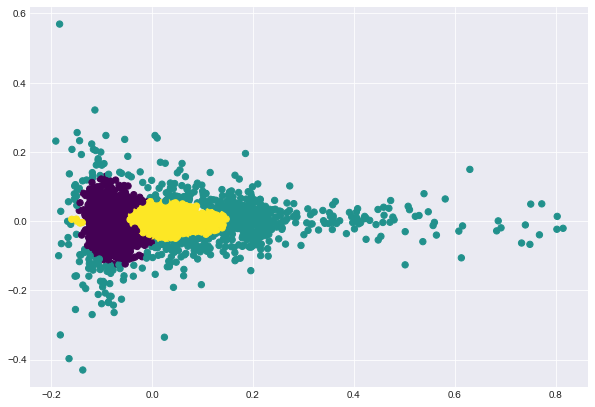

In [207]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = gmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

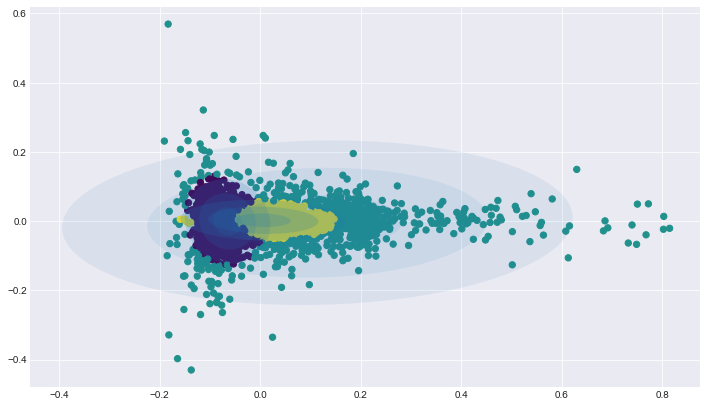

In [208]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(model, ax=ax)

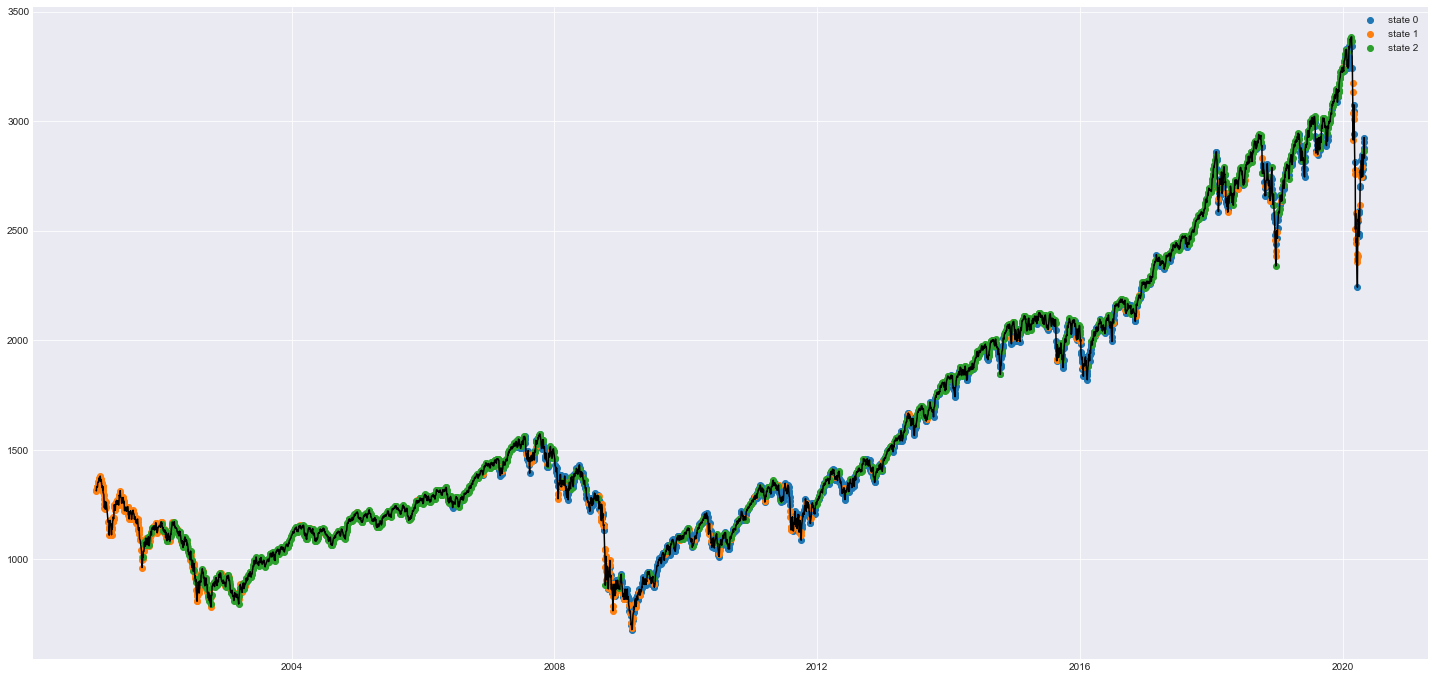

In [209]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP], label="state " + str(pred_label))
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Bayesian Gaussian Mixture Model

In [213]:
model = BayesianGaussianMixture(n_components=3, max_iter=300)

pca, scaler, bgmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [214]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Per-sample average log-likelihood for test data: {}".format(bgmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, bgmm.predict(modeled_test_data))))

Per-sample average log-likelihood for test data: 3.2943934467339173
Silhouette score for test data: 0.30979152753083383


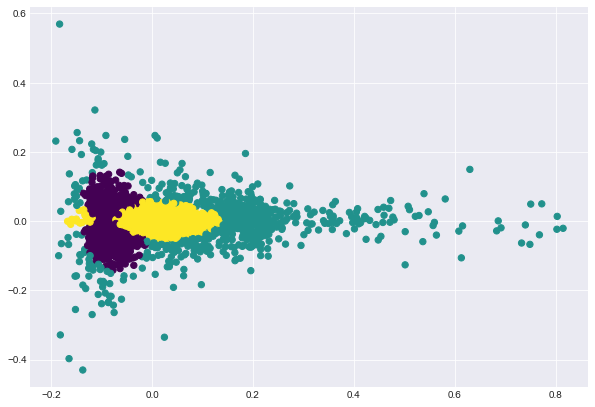

In [215]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = bgmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

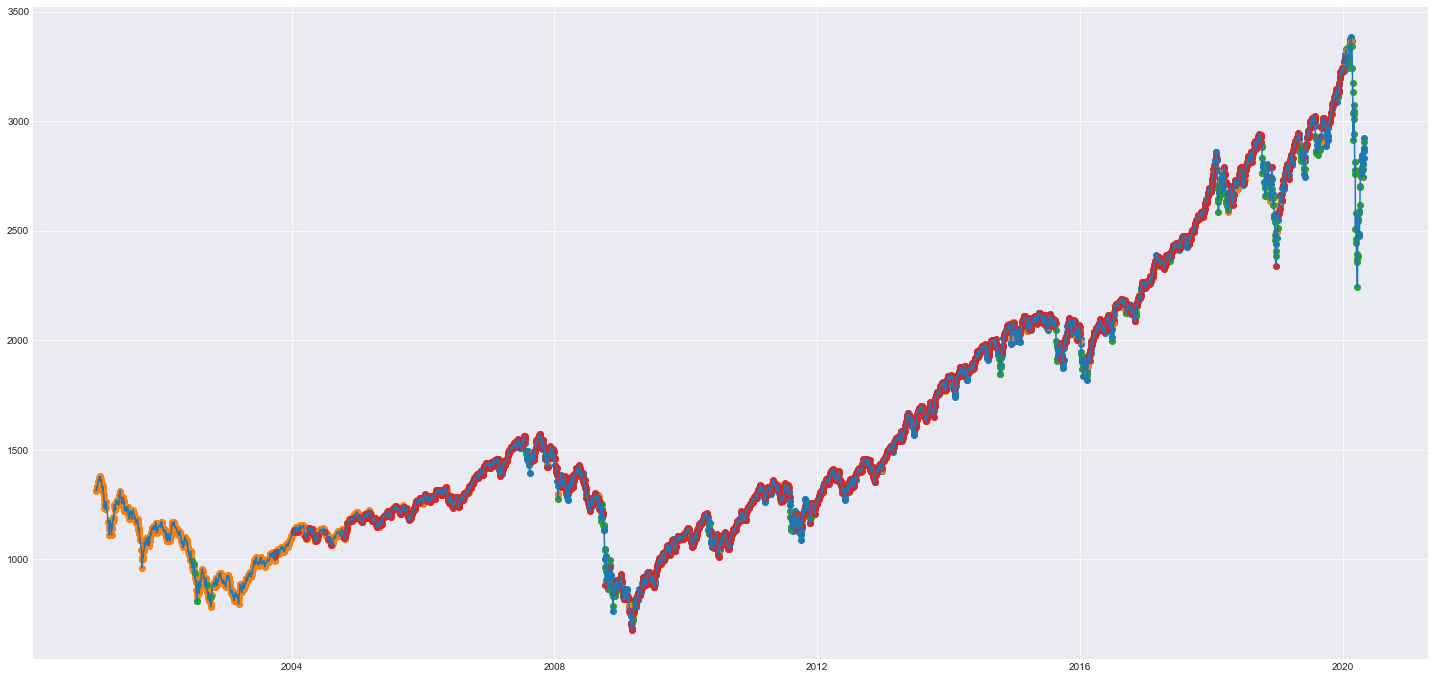

In [191]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP])
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP]);

### Hidden Markov Model

In [29]:
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100)

pca, scaler, ghmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [30]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Per-sample average log-likelihood for test data: {}".format(bgmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, ghmm.predict(modeled_test_data))))

Per-sample average log-likelihood for test data: 1.177637853350732
Silhouette score for test data: 0.28933232211734583


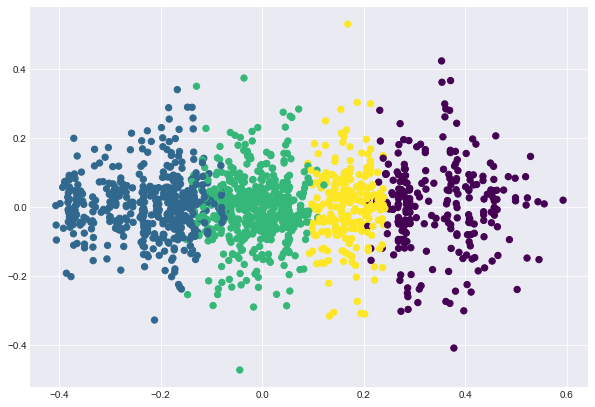

In [31]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = ghmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

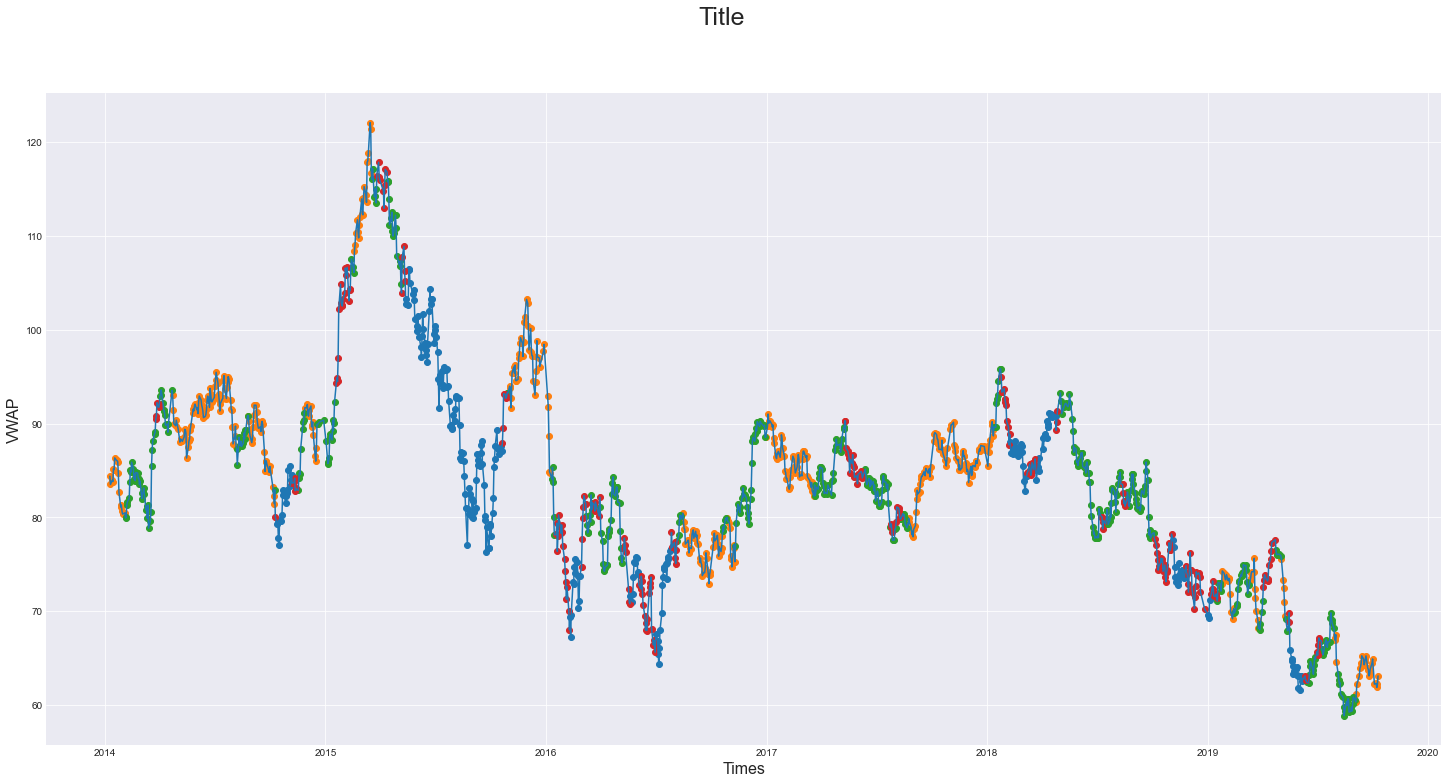

In [32]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
fig.suptitle("Title", fontsize=25)
plt.xlabel("Times", fontsize=16)
plt.ylabel("VWAP", fontsize=16)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP])
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP]);

## Grid Search

In [61]:
def silhouette_scorer(model, train, test):
    model.fit(X)
    labels = np.unique(model.predict(test))
    sc = silhouette_score(test, labels)
    
    return sc

def transform_data(train_data, test_data, len_features):
    X_train = train_data.values
    X_test = test_data.values
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len_features > 2:
        pca = PCA(n_components=2)
        pca.fit(X_train_scaled)
        X_train_pca = pca.transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
    else:
        pca = None
        X_train_pca = X_train_scaled
        X_test_pca = X_test_scaled
        
    return X_train_pca, X_test_pca

class EvaluatedGMM:
    
    def __init__(self, n_components, covariance_type, max_iter, train_data, test_data, pca_flag=True):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.train_data = train_data[train_data.index.year < train_data.index[-1].year]
        self.validation_data = train_data[train_data.index.year >= train_data.index[-1].year]
        self.test_data = test_data
        self.scaler = MinMaxScaler().fit(self.train_data.values)
        self.features = train_data.columns
        if pca_flag > 2:
            self.pca = PCA(n_components=2).fit(self.scaler.transform(self.train_data.values))
        else:
            self.pca = None
        self.gmm = GaussianMixture(n_components=self.n_components, 
                                   covariance_type=self.covariance_type, 
                                   max_iter=self.max_iter, 
                                   n_init=2)
        
    def fit_model(self):
        if self.pca is not None:
            self.X_train = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            self.X_train = self.scaler.transform(self.train_data.values)
        self.gmm_fitted = self.gmm.fit(self.X_train)
        
    def compute_silhouette_score(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.validation_data.values))
        else:
            validation = self.scaler.transform(self.validation_data.values)
        
        prediction = self.gmm_fitted.predict(validation)
        labels = np.unique(prediction)
        if len(labels) < 2:
            self.silhouette_score = 0
        else:
            self.silhouette_score = silhouette_score(validation, prediction)   
        
        return self.silhouette_score
    
    def get_aic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
        
        return self.gmm_fitted.aic(validation)
    
    def get_bic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
            
        return self.gmm_fitted.bic(validation)
    
    def get_mean_bic_aic(self):
        
        return (self.get_bic()+self.get_aic())/2
    
    def get_params(self):
        dict_params = {'n_components': self.n_components, 
                       'covariance_type': self.covariance_type, 
                       'max_iter': self.max_iter}
        
        return dict_params
    
    def get_features(self):
        return self.features
    
class EvaluatedGaussianHMM:
    
    def __init__(self, n_components, covariance_type, max_iter, algo_type, train_data, test_data, pca_flag=True):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.algo_type = algo_type
        self.train_data = train_data[train_data.index.year < train_data.index[-1].year]
        self.validation_data = train_data[train_data.index.year >= train_data.index[-1].year]
        self.test_data = test_data
        self.scaler = MinMaxScaler().fit(self.train_data.values)
        self.features = train_data.columns
        if pca_flag > 2:
            self.pca = PCA(n_components=2).fit(self.scaler.transform(self.train_data.values))
        else:
            self.pca = None
        self.gaussianHMM = GaussianHMM(n_components=self.n_components, 
                                       covariance_type=self.covariance_type, 
                                       n_iter=self.max_iter, 
                                       algorithm=self.algo_type)
        
    def fit_model(self):
        if self.pca is not None:
            self.X_train = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            self.X_train = self.scaler.transform(self.train_data.values)
        self.gaussianHMM_fitted = self.gaussianHMM.fit(self.X_train)
        
    def compute_silhouette_score(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.validation_data.values))
        else:
            validation = self.scaler.transform(self.validation_data.values)
        
        prediction = self.gaussianHMM_fitted.predict(validation)
        labels = np.unique(prediction)
        if len(labels) < 2:
            self.silhouette_score = 0
        else:
            self.silhouette_score = silhouette_score(validation, prediction)   
        
        return self.silhouette_score
    
    def get_number_parameters(self):
        _, n_features = self.gaussianHMM_fitted.means_.shape
        if self.gaussianHMM_fitted.covariance_type == 'full':
            cov_params = self.gaussianHMM_fitted.n_components * n_features * (n_features + 1) / 2.
        elif self.gaussianHMM_fitted.covariance_type == 'diag':
            cov_params = self.gaussianHMM_fitted.n_components * n_features
        elif self.gaussianHMM_fitted.covariance_type == 'tied':
            cov_params = n_features * (n_features + 1) / 2.
        elif self.gaussianHMM_fitted.covariance_type == 'spherical':
            cov_params = self.gaussianHMM_fitted.n_components
        mean_params = n_features * self.gaussianHMM_fitted.n_components
        
        return int(cov_params + mean_params + self.gaussianHMM_fitted.n_components - 1)
    
    def get_aic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
        aic = -2 * self.gaussianHMM_fitted.score(validation) * validation.shape[0] + 2 * self.get_number_parameters()
        
        return aic
    
    def get_bic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
        bic = (-2 * self.gaussianHMM_fitted.score(validation) * validation.shape[0] + 
               self.get_number_parameters() * np.log(validation.shape[0]))
        
        return bic
    
    def get_mean_bic_aic(self):
        
        return (self.get_bic()+self.get_aic())/2
    
    def get_params(self):
        dict_params = {'n_components': self.n_components, 
                       'covariance_type': self.covariance_type, 
                       'max_iter': self.max_iter,
                       'algorithm': self.algo_type}
        
        return dict_params
    
    def get_features(self):
        return self.features
    
class EvaluatedBayesianGM:
    
    def __init__(self, n_components, covariance_type, max_iter, weight_concentration, train_data, test_data, pca_flag=True):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.weight_concentration = weight_concentration
        self.train_data = train_data[train_data.index.year < train_data.index[-1].year]
        self.validation_data = train_data[train_data.index.year >= train_data.index[-1].year]
        self.test_data = test_data
        self.scaler = MinMaxScaler().fit(self.train_data.values)
        self.features = train_data.columns
        if pca_flag > 2:
            self.pca = PCA(n_components=2).fit(self.scaler.transform(self.train_data.values))
        else:
            self.pca = None
        self.bayesianGM = BayesianGaussianMixture(n_components=self.n_components, 
                                                  covariance_type=self.covariance_type, 
                                                  max_iter=self.max_iter, 
                                                  weight_concentration_prior_type=self.weight_concentration)
        
    def fit_model(self):
        if self.pca is not None:
            self.X_train = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            self.X_train = self.scaler.transform(self.train_data.values)
        self.bayesianGM_fitted = self.bayesianGM.fit(self.X_train)
        
    def compute_silhouette_score(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.validation_data.values))
        else:
            validation = self.scaler.transform(self.validation_data.values)
        
        prediction = self.bayesianGM_fitted.predict(validation)
        labels = np.unique(prediction)
        if len(labels) < 2:
            self.silhouette_score = 0
        else:
            self.silhouette_score = silhouette_score(validation, prediction)   
        
        return self.silhouette_score
    
    def get_number_parameters(self):
        _, n_features = self.bayesianGM_fitted.means_.shape
        if self.bayesianGM_fitted.covariance_type == 'full':
            cov_params = self.bayesianGM_fitted.n_components * n_features * (n_features + 1) / 2.
        elif self.bayesianGM_fitted.covariance_type == 'diag':
            cov_params = self.bayesianGM_fitted.n_components * n_features
        elif self.bayesianGM_fitted.covariance_type == 'tied':
            cov_params = n_features * (n_features + 1) / 2.
        elif self.bayesianGM_fitted.covariance_type == 'spherical':
            cov_params = self.bayesianGM_fitted.n_components
        mean_params = n_features * self.bayesianGM_fitted.n_components
        
        return int(cov_params + mean_params + self.bayesianGM_fitted.n_components - 1)
    
    def get_aic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
        aic = -2 * self.bayesianGM_fitted.score(validation) * validation.shape[0] + 2 * self.get_number_parameters()
        
        return aic
    
    def get_bic(self):
        if self.pca is not None:
            validation = self.pca.transform(self.scaler.transform(self.train_data.values))
        else:
            validation = self.scaler.transform(self.train_data.values)
        bic = (-2 * self.bayesianGM_fitted.score(validation) * validation.shape[0] + 
               self.get_number_parameters() * np.log(validation.shape[0]))
        
        return bic
    
    def get_mean_bic_aic(self):
        
        return (self.get_bic()+self.get_aic())/2
    
    def get_params(self):
        dict_params = {'n_components': self.n_components, 
                       'covariance_type': self.covariance_type, 
                       'max_iter': self.max_iter, 
                       'weight_concentration_prior_type': self.weight_concentration}
        
        return dict_params
    
    def get_features(self):
        return self.features
    

def get_best_gmm(list_of_features):
    
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]

    dict_scores = {}
    dict_features = {}
#     features = [log_returns, adv_antilog, betas_mkt_impact, log_traded_vol]

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    model = EvaluatedGMM(n_comp, cov, iters, train_data, test_data)
                    model.fit_model()
                    sc = model.compute_silhouette_score()
                    dict_scores[sc] = model.get_params()
                    dict_features[sc] = model.get_features()

    max_sc = max(list(dict_scores.keys()))
    max_params = dict_scores.get(max_sc)
    features_used = dict_features.get(max_sc)
    print("Optimal params are {} using {} obtaining a Silhouette Score of {}".format(max_params, list(features_used), max_sc))

    best_model = GaussianMixture(n_components=max_params.get('n_components'), 
                                 covariance_type=max_params.get('covariance_type'), 
                                 max_iter=max_params.get('max_iter'), 
                                 n_init=3)
    
    return best_model, features_used;

def get_best_ghmm(list_of_features):
    
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]
    algorithms = ['viterbi', 'map']
    
    dict_scores = {}
    dict_features = {}
#     features = [log_returns, adv_antilog, betas_mkt_impact, log_traded_vol, mfi]

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    for algo in algorithms:
                        model = EvaluatedGaussianHMM(n_comp, cov, iters, algo, train_data, test_data)
                        model.fit_model()
                        sc = model.compute_silhouette_score()
                        dict_scores[sc] = model.get_params()
                        dict_features[sc] = model.get_features()

    max_sc = max(list(dict_scores.keys()))
    max_params = dict_scores.get(max_sc)
    features_used = dict_features.get(max_sc)
    print("Optimal params are {} using {} obtaining a Silhouette Score of {}".format(max_params, list(features_used), max_sc))

    best_model = GaussianHMM(n_components=max_params.get('n_components'), 
                             covariance_type=max_params.get('covariance_type'),
                             n_iter=max_params.get('max_iter'), 
                             algorithm=max_params.get('algorithm'))
    
    return best_model, features_used;

def get_best_bgm(list_of_features):
    
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]
    w_c_types = ['dirichlet_process', 'dirichlet_distribution']
    
    dict_scores = {}
    dict_features = {}
#     features = [log_returns, adv_antilog, betas_mkt_impact, log_traded_vol]

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    for w_c_type in w_c_types:
                        model = EvaluatedBayesianGM(n_comp, cov, iters, w_c_type, train_data, test_data)
                        model.fit_model()
                        sc = model.compute_silhouette_score()
                        dict_scores[sc] = model.get_params()
                        dict_features[sc] = model.get_features()

    max_sc = max(list(dict_scores.keys()))
    max_params = dict_scores.get(max_sc)
    features_used = dict_features.get(max_sc)
    print("Optimal params are {} using {} obtaining a Silhouette Score of {}".format(max_params, list(features_used), max_sc))

    best_model = BayesianGaussianMixture(n_components=max_params.get('n_components'), 
                             covariance_type=max_params.get('covariance_type'),
                             max_iter=max_params.get('max_iter'), 
                             weight_concentration_prior_type=max_params.get('weight_concentration_prior_type'))
    
    return best_model, features_used;

In [62]:
def get_best_gmm_aic_bic(list_of_features, pca_flag=True):
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]

    dict_sc = {}
    dict_features = {}
    dict_bic = {}
    dict_aic = {}
    dict_score = {}

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    model = EvaluatedGMM(n_comp, cov, iters, train_data, test_data, pca_flag)
                    model.fit_model()
                    mean_bic_aic = model.get_mean_bic_aic()
                    dict_bic[mean_bic_aic] = model.get_bic()
                    dict_aic[mean_bic_aic] = model.get_aic()
                    sc = model.compute_silhouette_score()
                    dict_sc[mean_bic_aic] = sc
                    dict_score[mean_bic_aic] = model.get_params()
                    dict_features[mean_bic_aic] = model.get_features()

    max_sc = max(list(dict_sc.values()))
    min_bic_aic = min(list(dict_score.keys()))
    aic = dict_aic.get(min_bic_aic)
    bic = dict_bic.get(min_bic_aic)
    silhouette = dict_sc.get(min_bic_aic) 
    max_params = dict_score.get(min_bic_aic)
    features_used = dict_features.get(min_bic_aic)
    print("Optimal params are {} using {} obtaining a Combined BIC-AIC score of {}".format(max_params, list(features_used), min_bic_aic))
    print("Scores obtained -> BIC: {}, AIC: {}, SC: {}".format(bic, aic, silhouette))

    best_model = GaussianMixture(n_components=max_params.get('n_components'), 
                                 covariance_type=max_params.get('covariance_type'), 
                                 max_iter=max_params.get('max_iter'), 
                                 n_init=3)
    
    return best_model, features_used;

def get_best_ghmm_aic_bic(list_of_features, pca_flag=True):
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]
    algorithms = ['viterbi', 'map']
    
    dict_sc = {}
    dict_features = {}
    dict_bic = {}
    dict_aic = {}
    dict_score = {}

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    for algo in algorithms:
                        model = EvaluatedGaussianHMM(n_comp, cov, iters, algo, train_data, test_data, pca_flag)
                        model.fit_model()
                        mean_bic_aic = model.get_mean_bic_aic()
                        dict_bic[mean_bic_aic] = model.get_bic()
                        dict_aic[mean_bic_aic] = model.get_aic()
                        sc = model.compute_silhouette_score()
                        dict_sc[mean_bic_aic] = sc
                        dict_score[mean_bic_aic] = model.get_params()
                        dict_features[mean_bic_aic] = model.get_features()

    max_sc = max(list(dict_sc.values()))
    min_bic_aic = min(list(dict_score.keys()))
    aic = dict_aic.get(min_bic_aic)
    bic = dict_bic.get(min_bic_aic)
    silhouette = dict_sc.get(min_bic_aic) 
    max_params = dict_score.get(min_bic_aic)
    features_used = dict_features.get(min_bic_aic)
    print("Optimal params are {} using {} obtaining a Combined BIC-AIC score of {}".format(max_params, list(features_used), min_bic_aic))
    print("Scores obtained -> BIC: {}, AIC: {}, SC: {}".format(bic, aic, silhouette))

    best_model = GaussianHMM(n_components=max_params.get('n_components'), 
                             covariance_type=max_params.get('covariance_type'),
                             n_iter=max_params.get('max_iter'), 
                             algorithm=max_params.get('algorithm'))
    
    return best_model, features_used;

def get_best_bgm_aic_bic(list_of_features, pca_flag=True):
    n_components = [2,3,4]
    cov_type = ['full', 'diag', 'spherical', 'tied']
    max_iter = [100, 200, 400, 800]
    w_c_types = ['dirichlet_process', 'dirichlet_distribution']
          
    dict_sc = {}
    dict_features = {}
    dict_bic = {}
    dict_aic = {}
    dict_score = {}

    for features_combination in list(powerset(list_of_features)):
        features_df = getFeaturesDf(features_combination)
        train_data, test_data = splitTrainTestData(features_df, 2)
        for n_comp in n_components:
            for cov in cov_type:
                for iters in max_iter:
                    for w_c_type in w_c_types:
                        model = EvaluatedBayesianGM(n_comp, cov, iters, w_c_type, train_data, test_data, pca_flag)
                        model.fit_model()
                        mean_bic_aic = model.get_mean_bic_aic()
                        dict_bic[mean_bic_aic] = model.get_bic()
                        dict_aic[mean_bic_aic] = model.get_aic()
                        sc = model.compute_silhouette_score()
                        dict_sc[mean_bic_aic] = sc
                        dict_score[mean_bic_aic] = model.get_params()
                        dict_features[mean_bic_aic] = model.get_features()

    max_sc = max(list(dict_sc.values()))
    min_bic_aic = min(list(dict_score.keys()))
    aic = dict_aic.get(min_bic_aic)
    bic = dict_bic.get(min_bic_aic)
    silhouette = dict_sc.get(min_bic_aic) 
    max_params = dict_score.get(min_bic_aic)
    features_used = dict_features.get(min_bic_aic)
    print("Optimal params are {} using {} obtaining a Combined BIC-AIC score of {}".format(max_params, list(features_used), min_bic_aic))
    print("Scores obtained -> BIC: {}, AIC: {}, SC: {}".format(bic, aic, silhouette))

    best_model = BayesianGaussianMixture(n_components=max_params.get('n_components'), 
                             covariance_type=max_params.get('covariance_type'),
                             max_iter=max_params.get('max_iter'), 
                             weight_concentration_prior_type=max_params.get('weight_concentration_prior_type'))
    
    return best_model, features_used;

In [38]:
get_best_gmm()

Optimal params are {'n_components': 4, 'covariance_type': 'spherical', 'max_iter': 800} using ['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'] obtaining a Silhouette Score of 0.48768631169976545


(GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=800,
                 means_init=None, n_components=4, n_init=3, precisions_init=None,
                 random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                 verbose_interval=10, warm_start=False, weights_init=None),
 Index(['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'], dtype='object'))

In [39]:
get_best_ghmm()

Optimal params are {'n_components': 3, 'covariance_type': 'tied', 'max_iter': 100, 'algorithm': 'map'} using ['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'] obtaining a Silhouette Score of 0.5918586754049746


(GaussianHMM(algorithm='map', covariance_type='tied', covars_prior=0.01,
             covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
             min_covar=0.001, n_components=3, n_iter=100, params='stmc',
             random_state=None, startprob_prior=1.0, tol=0.01,
             transmat_prior=1.0, verbose=False),
 Index(['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'], dtype='object'))

In [40]:
get_best_bgm()

Optimal params are {'n_components': 4, 'covariance_type': 'spherical', 'max_iter': 100, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'] obtaining a Silhouette Score of 0.48768631169976545


(BayesianGaussianMixture(covariance_prior=None, covariance_type='spherical',
                         degrees_of_freedom_prior=None, init_params='kmeans',
                         max_iter=100, mean_precision_prior=None,
                         mean_prior=None, n_components=4, n_init=1,
                         random_state=None, reg_covar=1e-06, tol=0.001,
                         verbose=0, verbose_interval=10, warm_start=False,
                         weight_concentration_prior=None,
                         weight_concentration_prior_type='dirichlet_distribution'),
 Index(['log_returns', 'antilog_adv', 'betas_market_impact', 'volume'], dtype='object'))

## Eval

In [19]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[7]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

df = formatData(raw)

# df = df[df.index.year >= 2014]

current_ticker = df.ticker.iloc[0]

open_time = df.time.min()
last_time = df.time.max()
close_time = df[df[TIME] != df.time.max()].time.max()

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]

df_resampled = df.resample('5T').sum()

df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]

df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]
intraday_data = df_resampled.copy()

daily_data = get_daily_data(df)

train_intraday_data, test_data = splitTrainTestData(intraday_data, 2)

## Generate features

In [20]:
log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

# features = [log_returns, adv_antilog, mfi, betas_mkt_impact, log_traded_vol]
# features = [adv_antilog, mfi]
# features = [log_returns, betas_mkt_impact, log_traded_vol, adv_antilog]
features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]

features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

In [29]:
best_gmm, features_gmm = get_best_gmm_aic_bic(features)
best_ghmm, features_ghmm = get_best_ghmm_aic_bic(features)
best_bgm, features_bgm = get_best_bgm_aic_bic(features)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200} using ['volume', 'money_flow_index', 'log_returns'] obtaining a Combined BIC-AIC score of -26600.84705702487
Scores obtained -> BIC: -26527.5511890009, AIC: -26674.142925048836, SC: 0.27523736824010875
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100, 'algorithm': 'map'} using ['volume', 'money_flow_index', 'log_returns'] obtaining a Combined BIC-AIC score of -145617447.63881308
Scores obtained -> BIC: -145617374.34294507, AIC: -145617520.93468112, SC: 0.5169239044605168
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'money_flow_index', 'log_returns'] obtaining a Combined BIC-AIC score of -26485.132465200117
Scores obtained -> BIC: -26411.83659717615, AIC: -26558.428333224085, SC: 0.21026573392984355


In [53]:
features_df

,volume,betas_market_impact,money_flow_index,antilog_adv,log_returns
2001-01-09,11.695089,-40.846793,1.566252e+08,1.167270e+05,0.002095
2001-01-10,11.656142,13.896363,1.515849e+08,1.160606e+05,-0.010241
2001-01-11,11.787074,13.910676,1.732395e+08,1.167270e+05,-0.007144
2001-01-12,11.468514,83.605248,1.274616e+08,1.160606e+05,0.003378
2001-01-15,11.594257,-31.908351,1.445132e+08,1.153980e+05,0.000188
...,...,...,...,...,...
2020-04-27,13.964093,237.442129,3.255587e+09,1.894278e+06,-0.010640
2020-04-28,13.953801,18.477229,3.284834e+09,1.847624e+06,-0.015104
2020-04-29,14.282206,81.657183,4.607265e+09,1.824143e+06,-0.020213
2020-04-30,14.318730,88.716236,4.855288e+09,1.803067e+06,0.033133


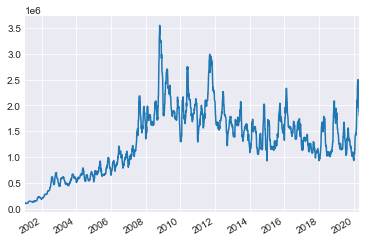

In [60]:
features_df['antilog_adv'].plot();

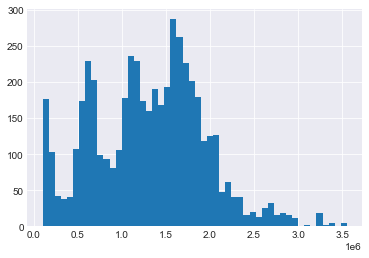

In [59]:
features_df['antilog_adv'].hist(bins=50);

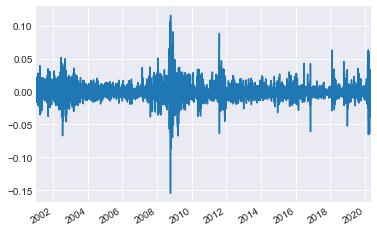

In [58]:
features_df['log_returns'].plot();

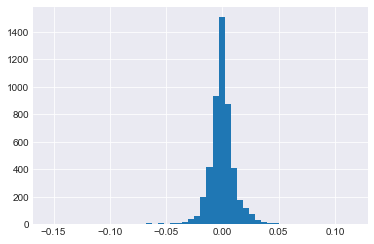

In [57]:
features_df['log_returns'].hist(bins=50);

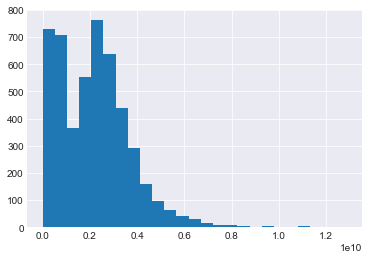

In [55]:
features_df['money_flow_index'].hist(bins=25)

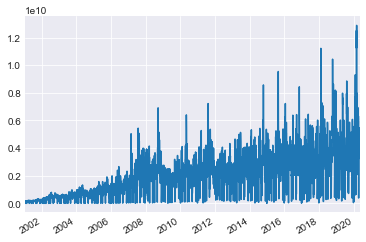

In [54]:
features_df['money_flow_index'].plot()

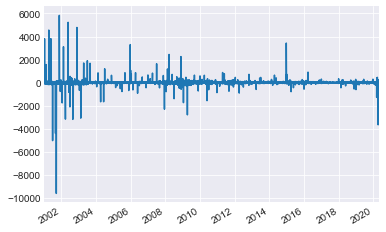

In [52]:
features_df['betas_market_impact'].plot();

### Gaussian Mixture Model

In [30]:
train_gmm, test_gmm = splitTrainTestData(features_df[features_gmm], 2)
full_data_gmm = features_df[features_gmm]

In [31]:
pca, scaler, gmm = fit_model_to_evaluate(best_gmm, train_gmm, len(features_gmm))

In [32]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_gmm.values))
else:
    modeled_test_data = scaler.transform(test_gmm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

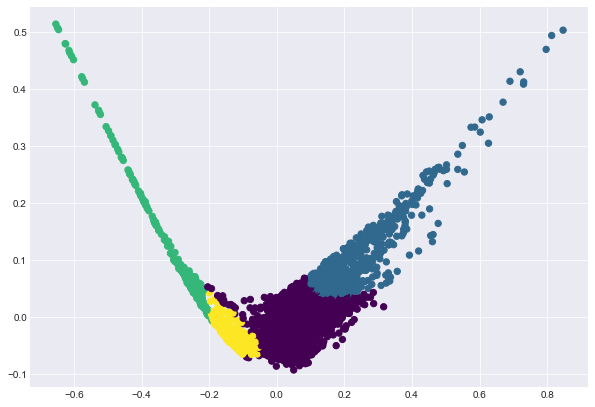

In [33]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_gmm.values))
else:
    full_data = scaler.transform(full_data_gmm.values)

predictions = gmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

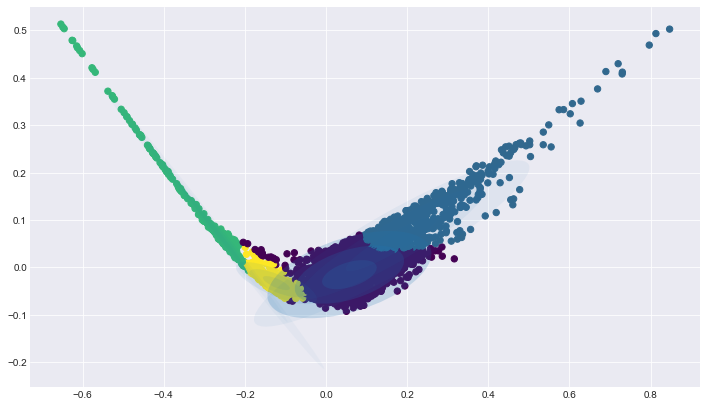

In [34]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(gmm, ax=ax)

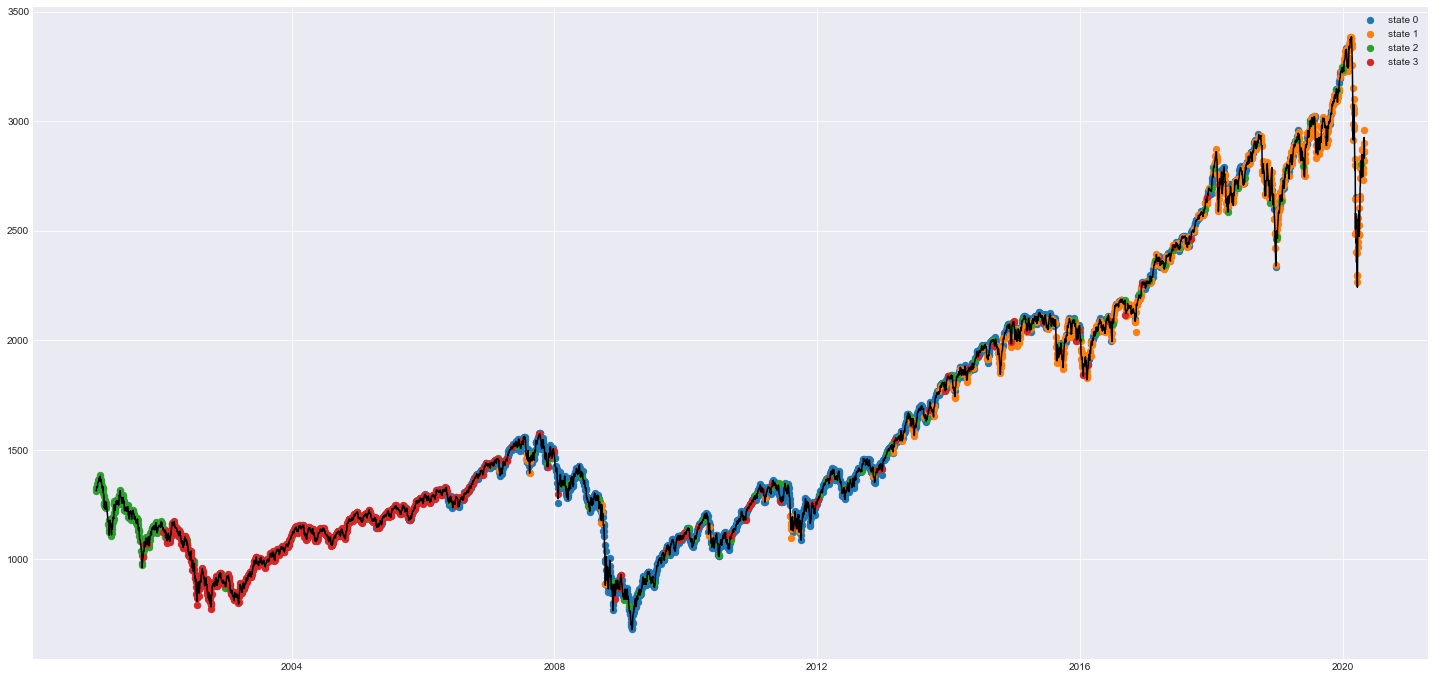

In [35]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Bayesian Gaussian Mixture

In [36]:
train_bgm, test_bgm = splitTrainTestData(features_df[features_bgm], 2)
full_data_bgm = features_df[features_bgm]

In [37]:
pca, scaler, bgm = fit_model_to_evaluate(best_bgm, train_bgm, len(features_bgm))

In [38]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_bgm.values))
else:
    modeled_test_data = scaler.transform(test_bgm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

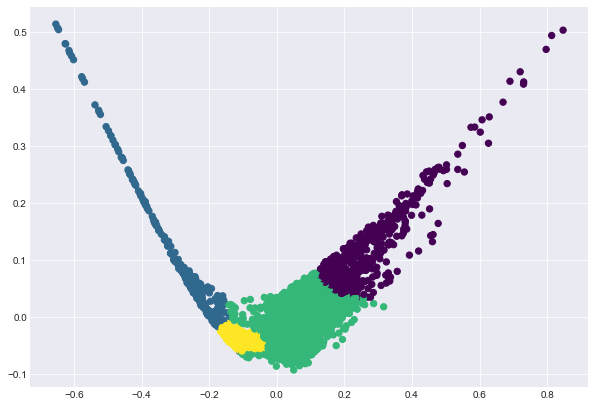

In [39]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_bgm.values))
else:
    full_data = scaler.transform(full_data_bgm.values)

predictions = bgm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

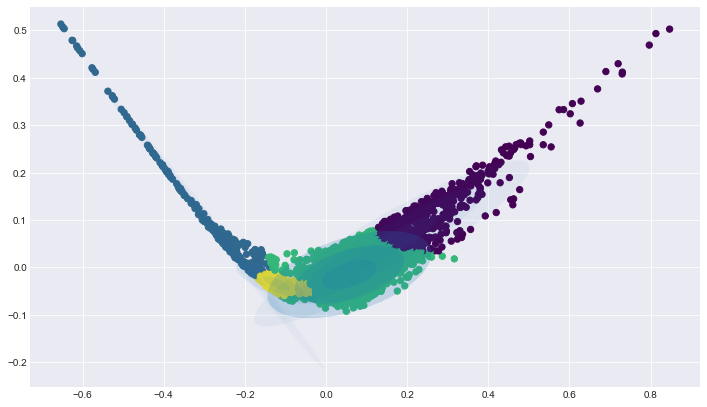

In [40]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(bgm, ax=ax)

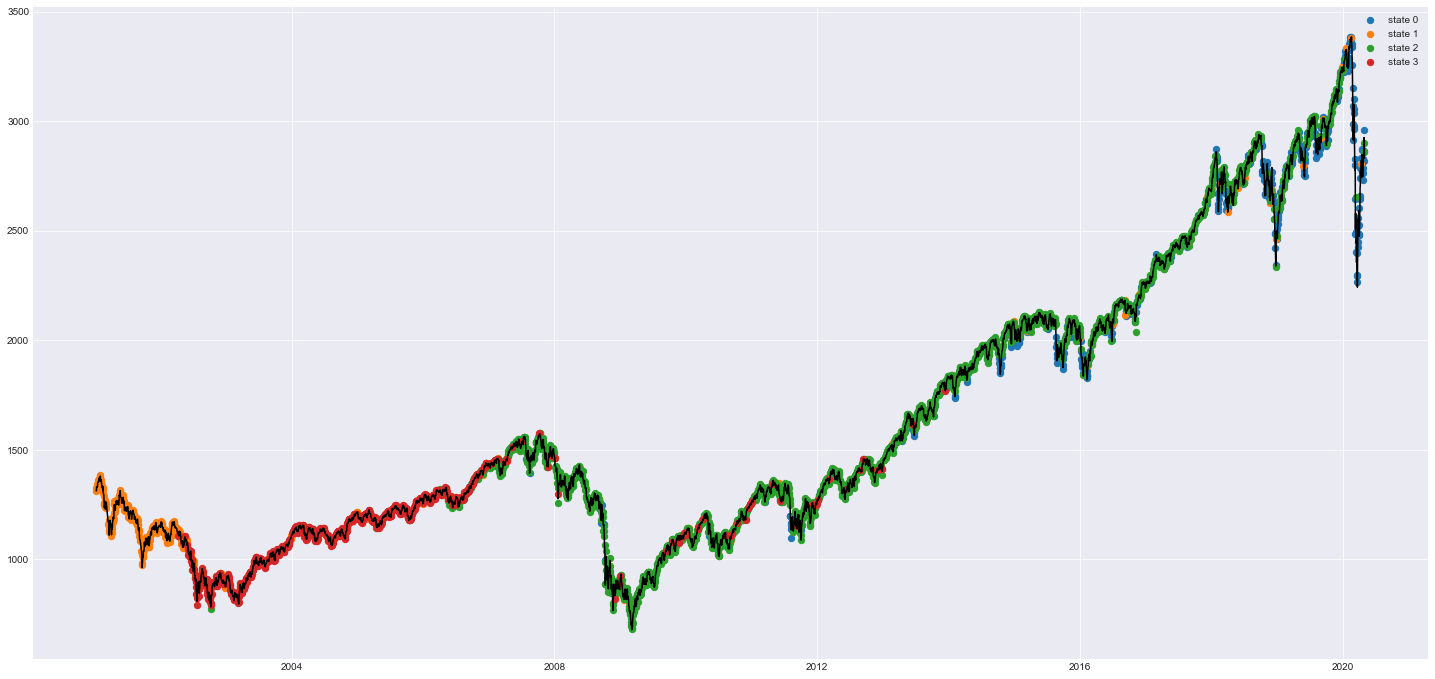

In [41]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_bgm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Gaussian Hidden Markov Model

In [42]:
train_ghmm, test_ghmm = splitTrainTestData(features_df[features_ghmm], 2)
full_data_ghmm = features_df[features_ghmm]

In [43]:
pca, scaler, ghmm = fit_model_to_evaluate(best_ghmm, train_ghmm, len(features_ghmm))

In [44]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_ghmm.values))
else:
    modeled_test_data = scaler.transform(test_ghmm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

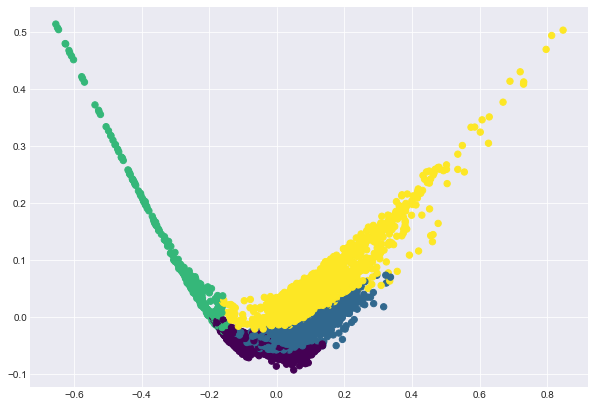

In [45]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_ghmm.values))
else:
    full_data = scaler.transform(full_data_ghmm.values)

predictions = ghmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

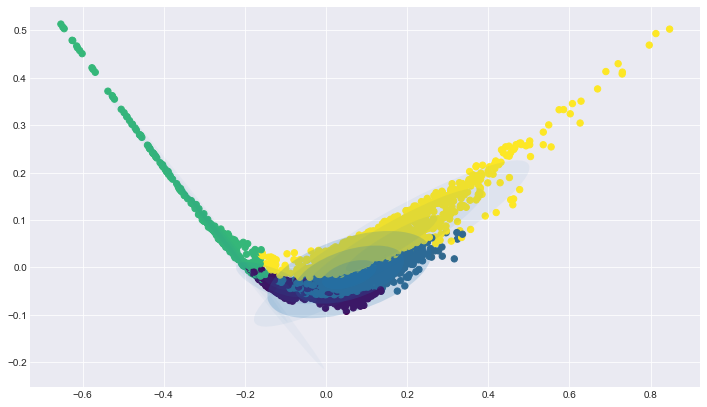

In [46]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(ghmm, ax=ax)

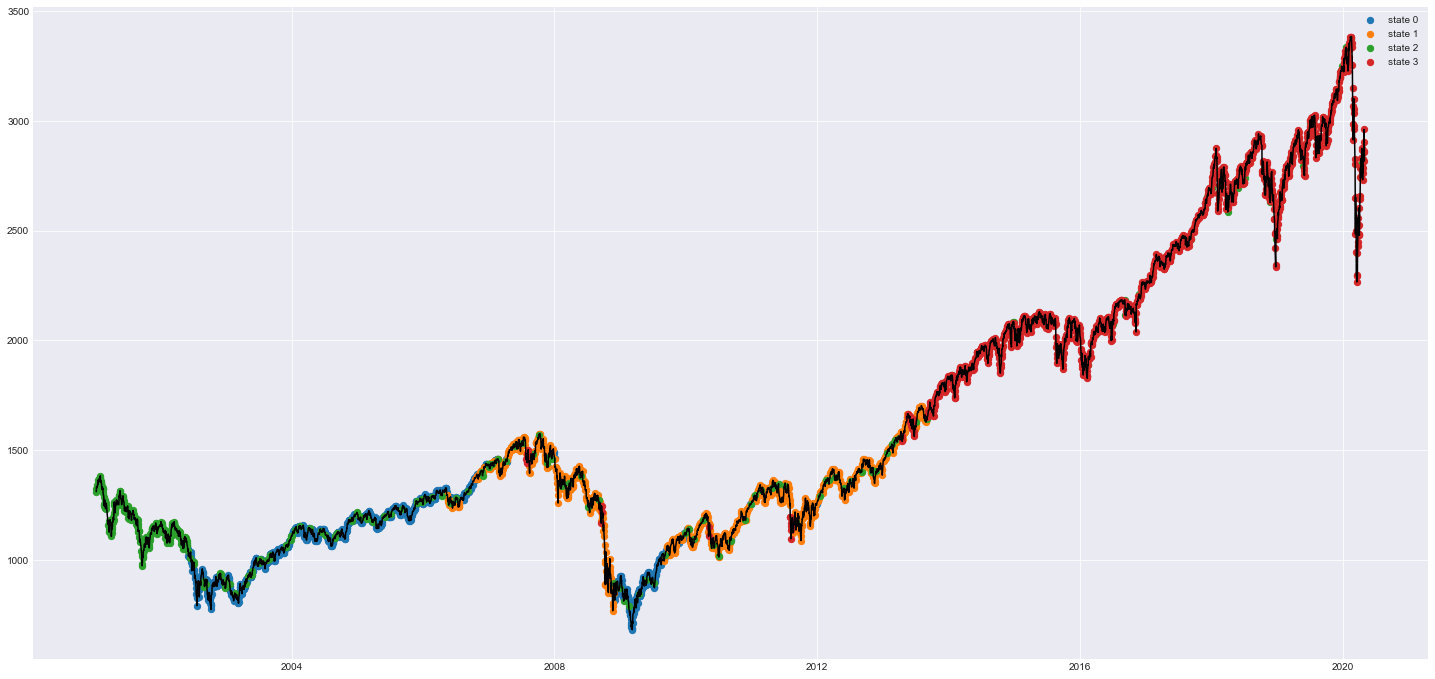

In [47]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_bgm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)]['close'], 'black');
plt.legend();

### Test without pca

In [63]:
best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -84669.38767235517
Scores obtained -> BIC: -84404.92353813583, AIC: -84933.8518065745, SC: 0.3775425677146312


In [64]:
train_gmm, test_gmm = splitTrainTestData(features_df[features_gmm], 2)
full_data_gmm = features_df[features_gmm]

In [87]:
pca, scaler, gmm = fit_model_to_evaluate(best_gmm, train_gmm, len(features_gmm), pca_flag=True)

In [90]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_gmm.values))
else:
    modeled_test_data = scaler.transform(test_gmm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

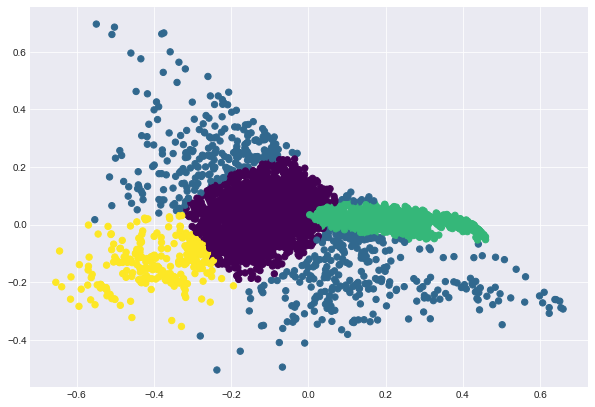

In [92]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_gmm.values))
else:
    full_data = scaler.transform(full_data_gmm.values)

predictions = gmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

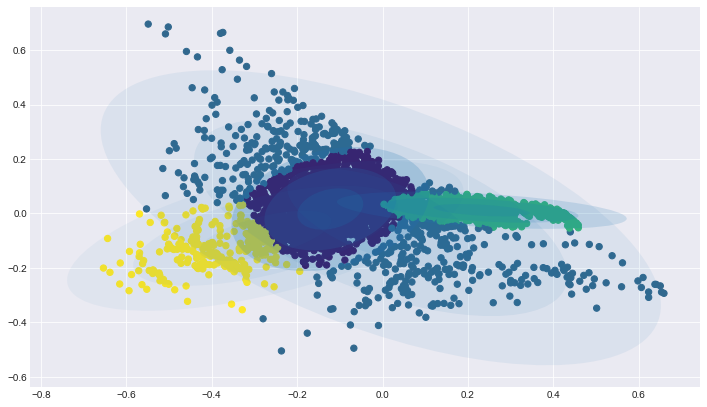

In [94]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(gmm, ax=ax)

**PCA**

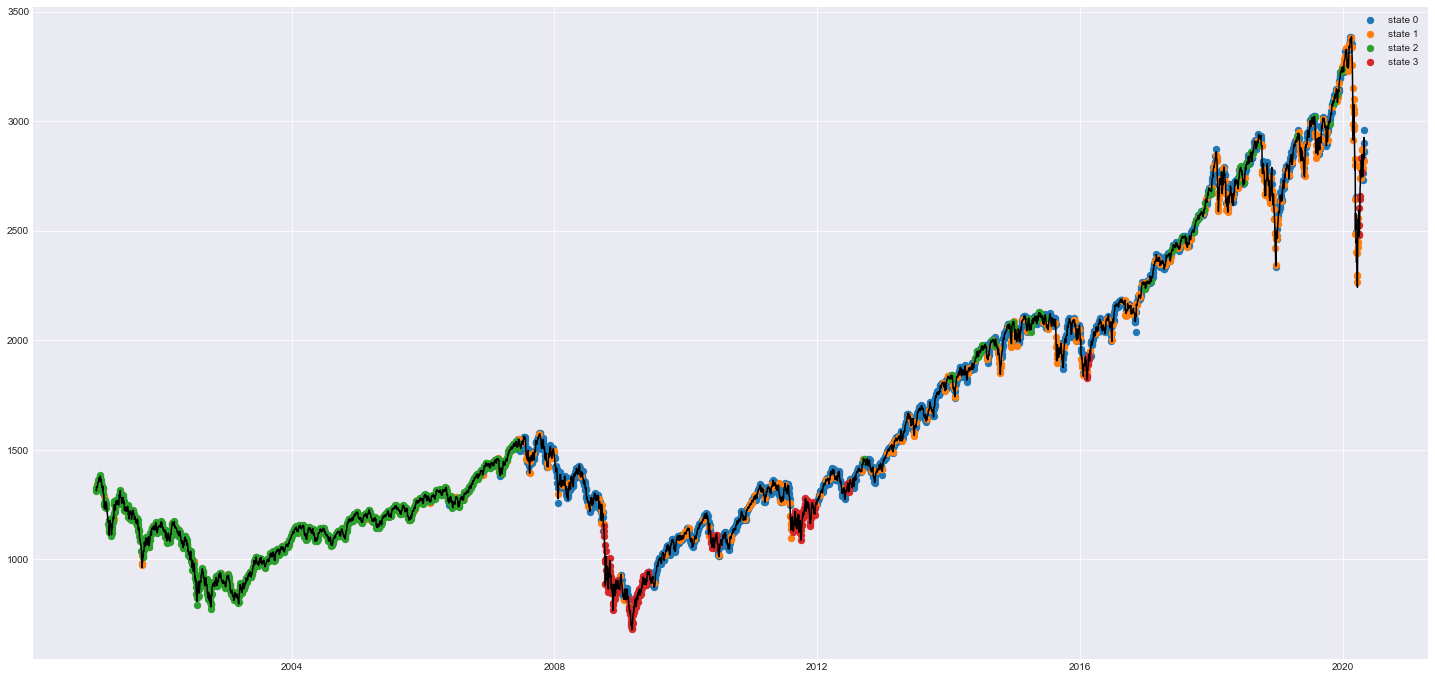

In [95]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

**NO PCA**

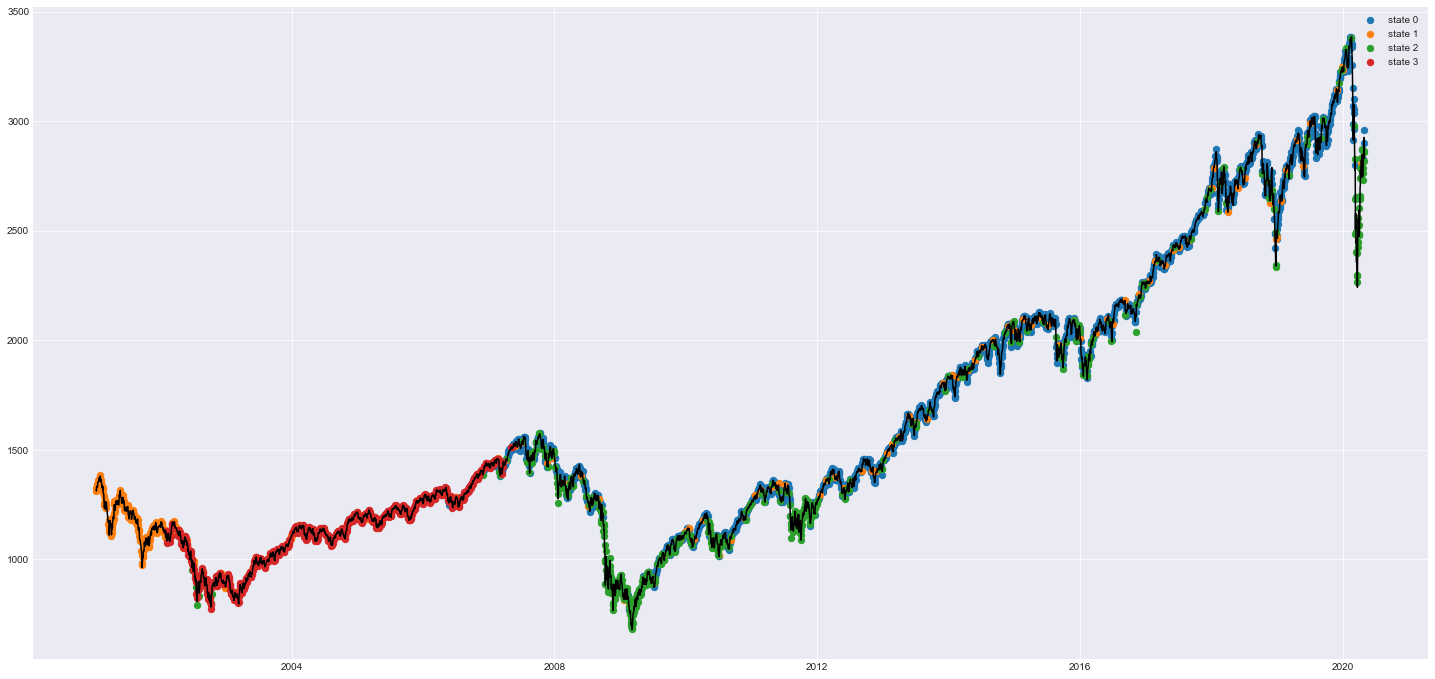

In [81]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Plotting

In [109]:
def plot_time_series_states(model, daily_data, features_df, features_to_use, ax, plot_title):
    train, test = splitTrainTestData(features_df[features_to_use], 2)
    data_to_use = features_df[features_to_use]

    pca, scaler, model_fitted = fit_model_to_evaluate(model, train, len(features_to_use), pca_flag=False)
    if pca is not None:
        full_data = pca.transform(scaler.transform(data_to_use.values))
    else:
        full_data = scaler.transform(data_to_use.values)
        
    predictions = model_fitted.predict(full_data)
        
    times = data_to_use.index
    for pred_label in np.unique(predictions):
        mask = predictions == pred_label
        ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
    ax.plot(times, daily_data[daily_data.index.isin(times)]['close'], 'black');
    ax.title.set_text(plot_title)
    ax.legend();

### SP 500

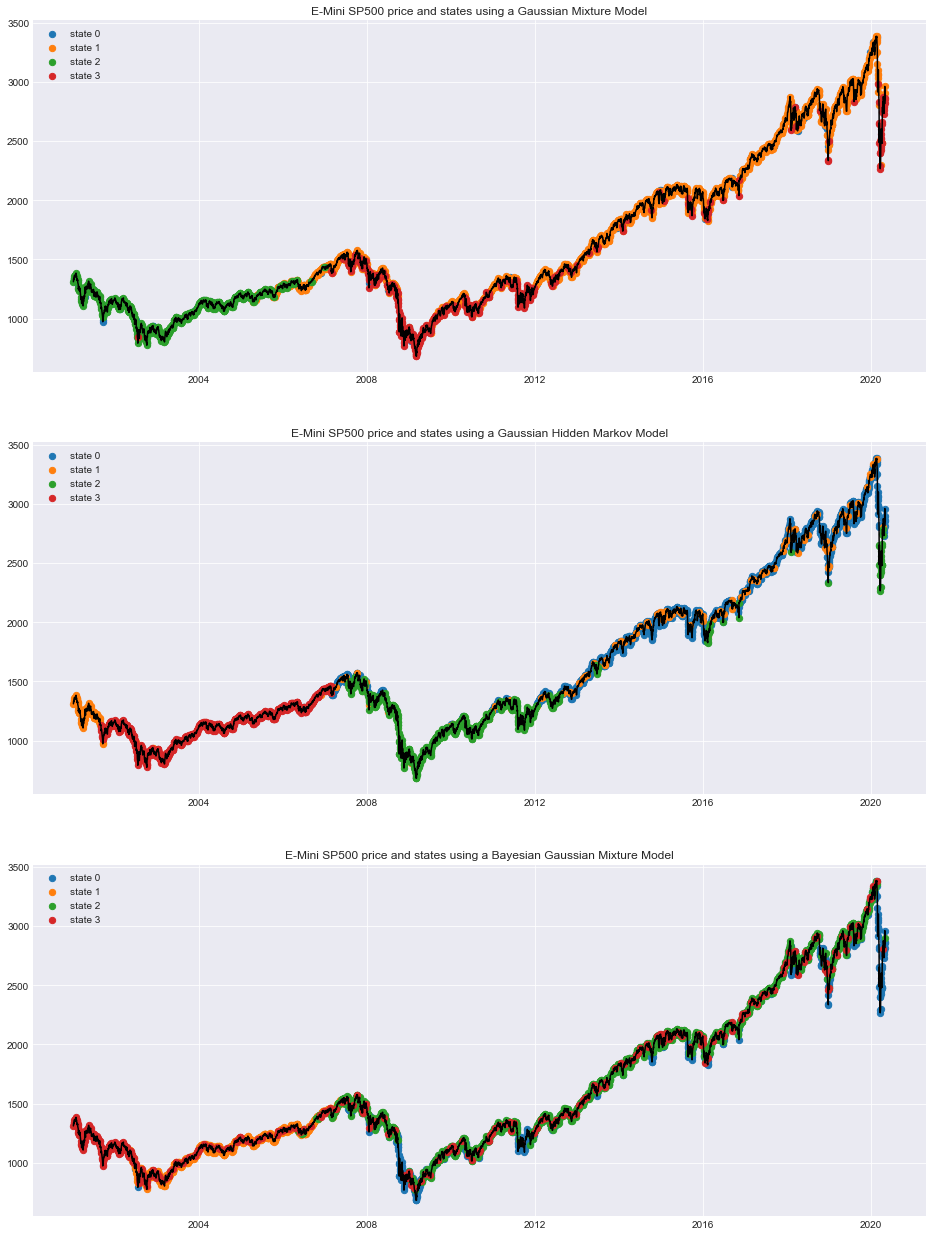

In [110]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[7]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "E-Mini SP500 price and states using a Gaussian Mixture Model"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "E-Mini SP500 price and states using a Gaussian Hidden Markov Model"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "E-Mini SP500 price and states using a Bayesian Gaussian Mixture Model"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

### BBVA

In [ ]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, "BBVA_MC.txt"), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "BBVA SP500 price and states using a Gaussian Mixture Model"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "BBVA price and states using a Gaussian Hidden Markov Model"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "BBVA SP500 price and states using a Bayesian Gaussian Mixture Model"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -46080.22000199861
Scores obtained -> BIC: -45817.6293987268, AIC: -46342.810605270424, SC: 0.38186687119412177
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -225637791.0573982
Scores obtained -> BIC: -225637528.46679494, AIC: -225638053.6480015, SC: -0.3283145253868127
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 400, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -46091.671608313496
Scores obtained -> BIC: -45829.0810050416

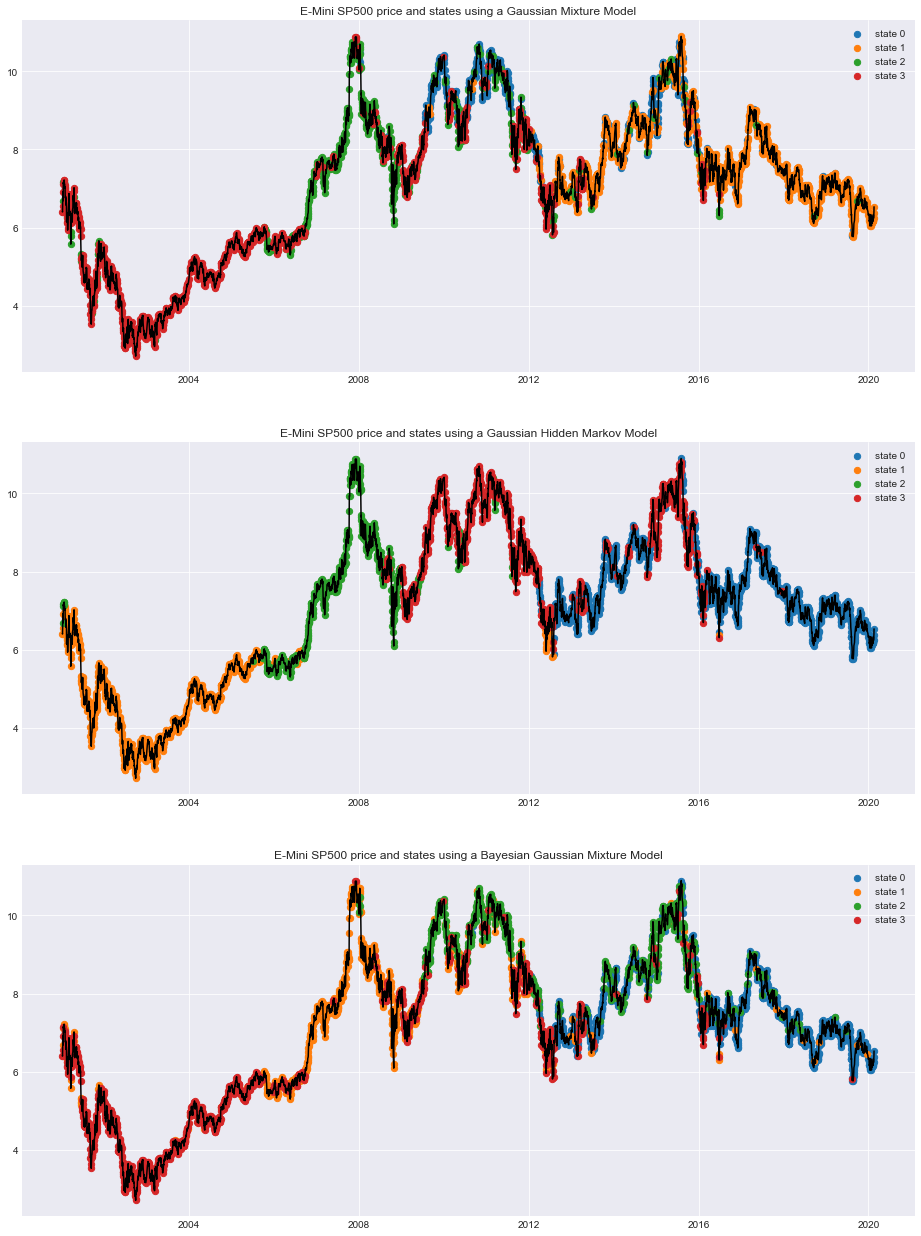

In [115]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, "TEF.txt"), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "E-Mini SP500 price and states using a Gaussian Mixture Model"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "E-Mini SP500 price and states using a Gaussian Hidden Markov Model"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "E-Mini SP500 price and states using a Bayesian Gaussian Mixture Model"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

### Get Scores per Model and Instrument

In [ ]:
def get_scores_per_model(file):
    raw = pd.read_csv("file:///" + os.path.join(DATAPATH, file), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
    df = formatData(raw)

    current_ticker = df.ticker.iloc[0]

    df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
    daily_data = get_daily_data(df)

    log_returns = get_log_returns(daily_data)
    adv_antilog = get_antilog_adv_median(daily_data)
    mfi = get_money_flow_index(daily_data)
    betas_mkt_impact = get_beta_market_impact(daily_data)
    log_traded_vol = get_log_total_trade_vol(daily_data)

    features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
    features_df = getFeaturesDf(features)

    train_data, test_data = splitTrainTestData(features_df, 2)

    best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
    best_ghmm, features_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
    best_bgm, features_bgm = get_best_bgm_aic_bic(features, pca_flag=False)
    
    
    
    